In [1]:
import petri_net_toolkit as pntk
from petri_net_toolkit.mini_fab_petri_nets import *
from petri_net_toolkit.timed_mini_fab_petri_nets import *
import numpy as np
import torch
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random
from tqdm import tqdm
import rl_utils

In [2]:
env = Sorter2p_Single_Timed('Sorter2p_Petri', control=True)

env.set_fire_bonus(5)
env.set_invalid_fire_penalty(-2)
env.set_time_period(1)
env.set_reworking_penalty(-20)
env.set_deadlock_penalty(-100)
env.set_dummy_penalty(-1)
env.initialize_net()
env.reset()
env.draw_net('Sorter2p_Colored_initial.png', show_note=True)

{'p1': {'default': 30}, 'p2': {'default': 0}, 'p3': {'default': 0}, 'p4': {'default': 0}, 'p5': {'default': 0}, 'p6': {'default': 0}, 'p7': {'default': 1}, 'p8': {'default': 1}}


/Users/jason/Documents/SJTU_pro/Projects/DTG/PetriNets/petri_net_toolkit/petri_nets_pro.py:220: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pt_matrix.loc[element.name] = np.zeros(len(self.pt_matrix.columns))


In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        return  F.softmax(self.fc4(x), dim=-1)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps      # PPO-Clip epsilon
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_list = torch.distributions.Categorical(probs)
        action = action_list.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()


        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) 
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [5]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
lmbda = 0.95
epochs = 10
eps = 0.4

In [6]:
state_dim = env.observation_space[0]
action_dim = env.action_space
print(state_dim)
print(action_dim)
torch.manual_seed(4)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

13
4


In [7]:
return_list = []
output_traj = []
output_traj_ = []
dict_list = []
output_time = []
T_list = []
for i in range(20):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            max_T = 300
            T = 0
            traj_o = []
            trig = np.zeros(env.action_dim)
            ## sample one sequence
            while (not done) and (T < max_T):
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward
                traj_o.append(env.places['p6'].token['default'])
                T += 1
                # print(state)
                # print(env.places['p20'].token['default_error'], env.places['p22'].token['default_error'])
                # if env.places['p20'].token['default_error'] != env.places['p22'].token['default_error']:
                #     print(action)
                # print(env.act_time)
                    
            T_list.append(T)
            output_traj.append(traj_o)
            output_time.append(env.act_time) 
            return_list.append(episode_return)
            dict_list.append(transition_dict)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/7x/vkxy_bn547d757f8znyxd6rh0000gn/T/ipykernel_66215/1716029588.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 19: 100%|██████████| 50/50 [00:00<00:00, 159.85it/s, episode=1000, return=12.000]


In [8]:
k = -1
for i in range(len(dict_list[k]['states'])):
    print(dict_list[k]['states'][i])

[1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
[0.96666667 0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.        ]
[0.96666667 0.         0.         0.         0.         0.
 0.         1.         0.5        0.         0.         0.
 0.        ]
[0.96666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.96666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.5        0.         0.
 0.        ]
[0.96666667 0.         1.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.        ]


In [9]:
for i in range(len(dict_list[k]['actions'])):
    print(dict_list[k]['actions'][i])

1
0
2
0
0
1


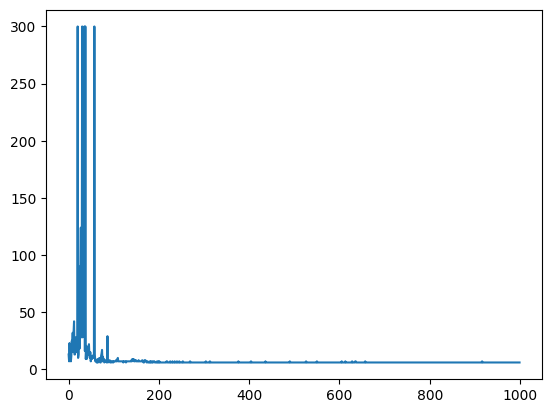

In [10]:
# ======= plot T =======
plt.plot(range(len(T_list)), T_list)

1000


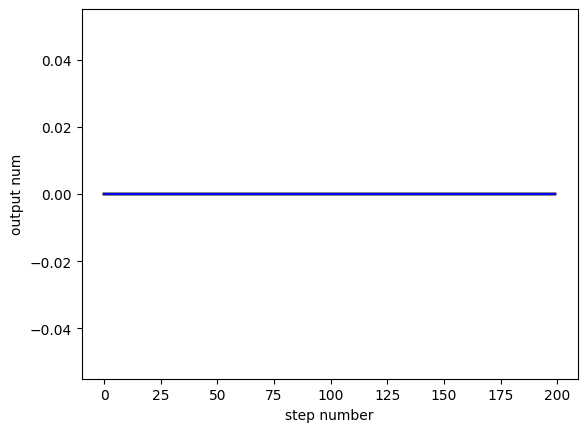

In [11]:
# ======= plot output traj =======
max_traj = max(len(traj) for traj in output_traj)
step_num = range(max_traj)
for traj in output_traj:
    traj.extend([traj[-1]] * (max_traj - len(traj)))
    
max_step = 200
for i in range(40):
    plt.plot(step_num[:max_step], output_traj[i][:max_step])

plt.plot(step_num[:max_step], output_traj[-1][:max_step], 'b-')
plt.xlabel('step number')
plt.ylabel('output num')
print(len(output_traj))

0


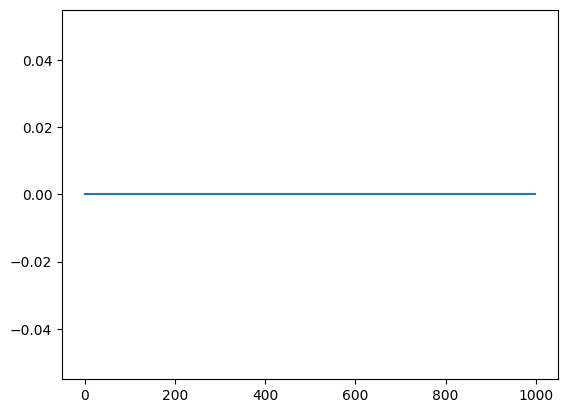

In [12]:
# ======= plot min finish time =======

print(output_time[-1])
plt.plot(range(len(output_time)), output_time)

[-19, 10, -19, -31, 5, -10, 3, -37, -13, -44, -18, -24, -37, 3, -1, -23, -32, -8, 3, -6, -356, -11, 4, -96, -3, -34, -67, -112, -10, -63, -299, -11, -74, -71, -35, -294, -1, -333, 8, -1, 8, -6, 2, -22, 2, -8, 2, 6, -2, 11, -14, 8, 9, 2, 4, 7, 6, -296, 2, 11, 9, 10, 12, 12, 6, 11, 11, 9, -13, 8, 12, -7, 6, 4, 1, 11, 7, 10, 8, 12, 11, 8, 10, 10, -7, 9, -12, 12, 11, 11, 11, 9, 12, 12, 11, 11, 12, 11, 11, 12, 11, 11, 11, 11, 11, 10, 11, 11, 9, 7, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, -8, 11, 11, 10, 11, 9, 10, 10, 7, 11, 10, 11, 10, 9, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 12, 12, 9, 10, 10, 11, 11, 12, 11, 11, 12, 11, 12, 12, 10, 11, 11, 12, 12, 11, 11, 12, 10, 11, 11, 12, 12, 12, 12, 11, 11, 12, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 12, 11, 11, 12, 12, 12, 11, 12, 12, 11, 12, 12, 11, 12, 10, 12, 12, 12, 12, 11, 12, 12, 12, 12, 11, 12, 12, 12, 12, 11, 11, 12, 11, 12

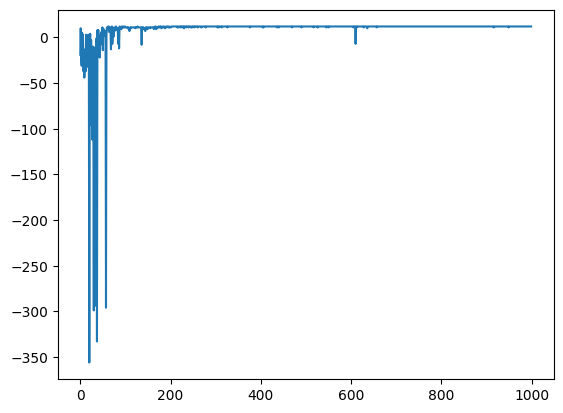

In [13]:
print(return_list)
plt.plot(range(len(return_list)), return_list)

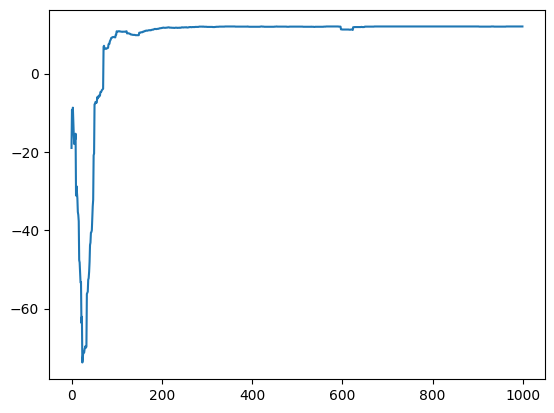

In [14]:
mv_return = rl_utils.moving_average(return_list, 27)
plt.plot(range(len(return_list)), mv_return)